In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np

path = "/content/drive/MyDrive/ColabNotebooks/MachineLearningCoursework/" # Change path to run program
train_x = np.load(path + "train_x.npy", allow_pickle=True)
train_y = np.load(path + "train_y.npy", allow_pickle=True)
test_x = np.load(path + "test_x.npy", allow_pickle=True)
test_y = np.load(path + "test_y.npy", allow_pickle=True)
valid_x = np.load(path + "valid_x.npy", allow_pickle=True)
valid_y = np.load(path + "valid_y.npy", allow_pickle=True)

Mounted at /content/drive


In [2]:
# Code used from view.ipynb provided
import matplotlib.pyplot as plt

def image_normalization(arr):
    return (arr - arr.min())/(arr.max()-arr.min())

def disable_ax_ticks(ax):
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)

def show_mnist_examples(x, y):
    fig = plt.figure(constrained_layout=True,figsize=(12,9), dpi=100)
    gs = fig.add_gridspec(3,4)
    main_ax = fig.add_subplot(gs[:3,:3])
    fig.suptitle(y)
    main_ax.imshow(image_normalization(np.moveaxis(x, 0, -1)))
    disable_ax_ticks(main_ax)

    for j in range(3):
      c_ax = fig.add_subplot(gs[j,-1])
      subimage = x.copy()
      subimage[:j] = 0
      subimage[j+1:] = 0
      subimage[j] = subimage[j]-subimage[j].min()
      c_ax.imshow(image_normalization(np.moveaxis(subimage, 0, -1)))
      disable_ax_ticks(c_ax)
    plt.show()

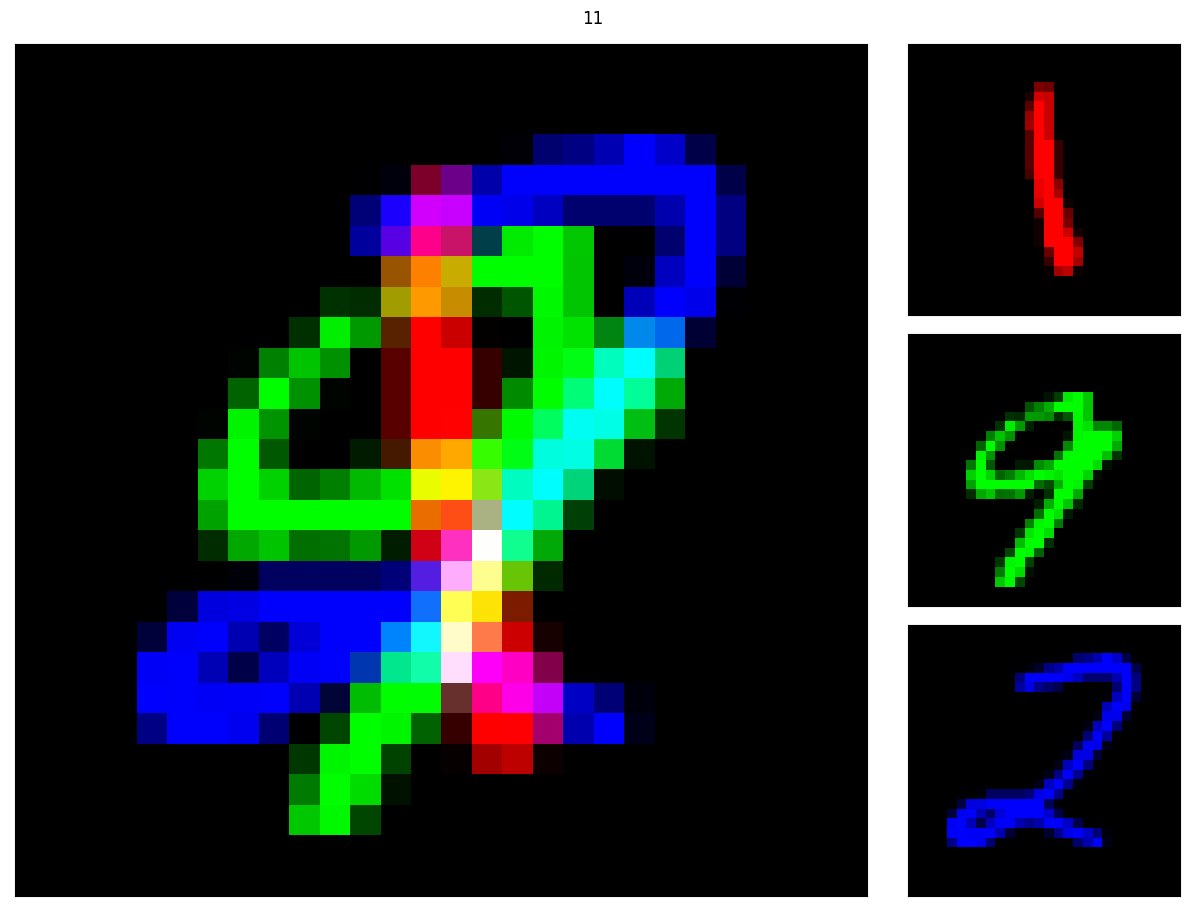

In [3]:
import random

# Display random image from training dataset
ri = random.randrange(train_x.shape[0])
show_mnist_examples(train_x[ri], train_y[ri])

# Reshape train, test and validate datasets to be channel last for the model
train_x = train_x.reshape(train_x.shape[0], 28, 28, 3)
test_x = test_x.reshape(test_x.shape[0], 28, 28, 3)
valid_x = valid_x.reshape(valid_x.shape[0], 28, 28, 3)

train_x = image_normalization(train_x)
test_x = image_normalization(test_x)
valid_x = image_normalization(valid_x)

Initially for the model for this task we studied the layers of the VGG16 model used for task 2, this was to understand the layers in the model and what they were doing. The layers used for VGG16 with the extra layers added for task 2 were tried for this task. However the train times per epoch for this model were far too long and the accuracies achieved were not sufficient. This provided some insight into what the layers in VGG16 were actually doing, but that solution was not going to work. After this research was conducted into custom-built machine learning models for images of size 28x28 which were much more useful. This provided more insight into what convolutional layers to use and the different types of pooling layers that could be used.

In [4]:
from tensorflow.keras import layers, models

model = models.Sequential([
  layers.InputLayer(train_x[0].shape),
  # First convolutional layer
  layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
  layers.BatchNormalization(),
  # Second convolutional layer
  layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
  layers.BatchNormalization(),
  # Pooling layer to downsample input
  layers.MaxPool2D(pool_size=(4, 4)),
  # Third convolutional layer
  layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
  layers.BatchNormalization(),
  # Fourth convolutional layer
  layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
  layers.BatchNormalization(),
  # Pooling layer
  layers.GlobalAveragePooling2D(),
  # Dense layer for prediction
  layers.Dense(units=20, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                        

50 epochs was chosen to stop the model from training for too long if early stopping hadn't stopped it by 50 epochs. Different learning rates were tested for this model, but the default learning rate of 0.001 for Adam ended up giving the best results.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile, fit and evaluate model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Stops model fitting if the accuracy of 3 epochs in a row is below the maximum
# accuracy achieved on a previous epoch
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

model_output = model.fit(x=train_x, y=train_y, epochs=50, validation_data=(valid_x, valid_y), callbacks=[es])
model.evaluate(test_x, test_y)

Epoch 1/50
1407/1407 [==============================] - 17s 6ms/step - loss: 2.1183 - accuracy: 0.2362 - val_loss: 1.7495 - val_accuracy: 0.3305
Epoch 2/50
1407/1407 [==============================] - 8s 5ms/step - loss: 1.7008 - accuracy: 0.3497 - val_loss: 1.5536 - val_accuracy: 0.4007
Epoch 3/50
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5235 - accuracy: 0.4142 - val_loss: 1.4534 - val_accuracy: 0.4429
Epoch 4/50
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4086 - accuracy: 0.4564 - val_loss: 1.3031 - val_accuracy: 0.5003
Epoch 5/50
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3125 - accuracy: 0.4939 - val_loss: 1.2538 - val_accuracy: 0.5148
Epoch 6/50
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2402 - accuracy: 0.5236 - val_loss: 1.1880 - val_accuracy: 0.5482
Epoch 7/50
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1688 - accuracy: 0.5519 - val_loss: 1.2113 - val_accuracy

[0.3559882342815399, 0.9111999869346619]

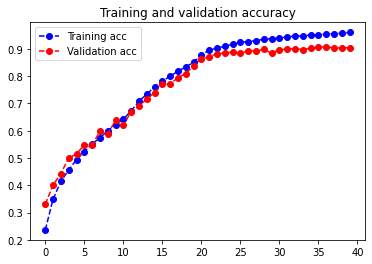

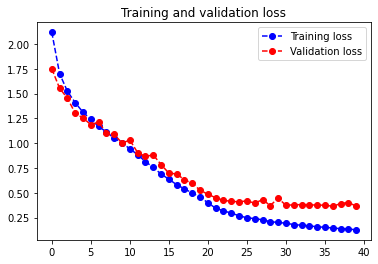

In [6]:
import matplotlib.pyplot as plt

acc = model_output.history['accuracy']
val_acc = model_output.history['val_accuracy']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']

epochs = range(len(acc))

# Displays a plot of the training accuracy and validation accuracy over each epoch
plt.plot(epochs, acc, 'bo--', label='Training acc')
plt.plot(epochs, val_acc, 'ro--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Displays a plot of the training loss and validation loss over each epoch
plt.plot(epochs, loss, 'bo--', label='Training loss')
plt.plot(epochs, val_loss, 'ro--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()